In [22]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.0
torch version: 2.5.1
tiktoken version: 0.8.0


In [23]:
# dictionary to specify the configuration of the GPT model
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "embedding_dim": 768,
    "n_heads": 12, #attention heads
    "n_layers": 12, #transformer blocks
    "dropout_rate": 0.1,
    "qkv_bias": False
}

Placeholder GPT class

In [24]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["embedding_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["embedding_dim"])
        self.drop_emb = nn.Dropout(cfg["dropout_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["embedding_dim"])
        self.out_head = nn.Linear(
            cfg["embedding_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

Tokenize

In [25]:
import tiktoken

# tokenizing two input strings
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
# encoding each token using tiktoken library
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


Logits - raw outputs before any activations

In [26]:
# initializing the gpt model with configuration
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(logits)
print(logits.shape)#2 sentences, 4 tokens in each, 50257 vocab size

tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)
torch.Size([2, 4, 50257])


Implementing Layer Norm

In [27]:
torch.manual_seed(123)
batch_example = torch.randn(2,5) #2 training examples, 5 features
# print(batch_example)

# create one layer with 5 input features and 6 output features
layer1 = nn.Sequential(nn.Linear(5,6), nn.ReLU())
layer1_out = layer1(batch_example)
print(layer1_out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [28]:
# mean and variance of the output of the first layer
# before normalization
mean = layer1_out.mean(dim=-1, keepdim=True)
variance = layer1_out.var(dim=-1, keepdim=True)
print(mean, variance)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>) tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [29]:
#applying layer norm to output
out_norm = (layer1_out - mean)/torch.sqrt(variance)
print(out_norm)
mean_norm = out_norm.mean(dim=-1, keepdim=True)
variance_norm = out_norm.var(dim=-1, keepdim=True)

# must have near 0 mean and 1 variance
print(mean_norm, variance_norm)

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>) tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [30]:
# creating a layer norm class
# this will later go in the gpt class

class LayerNorm(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(embedding_dim))
        self.bias = nn.Parameter(torch.zeros(embedding_dim))
        self.eps = 1e-5


    # pass the output of the first layer to this function
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, keepdim=True)
        out_norm = (x - mean) / torch.sqrt(variance + self.eps)
        return self.scale * out_norm + self.bias

In [33]:
ln = LayerNorm(5) #5 input features
out_ln = ln(batch_example)
mean_ln = out_ln.mean(dim=-1, keepdim=True)
variance_ln = out_ln.var(dim=-1, keepdim=True)
print(mean_ln, variance_ln)

tensor([[-1.4901e-08],
        [ 2.3842e-08]], grad_fn=<MeanBackward1>) tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


GeLU Activation 

In [34]:
class Gelu(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(0.79788456 * (x + 0.044715 * x**3)))

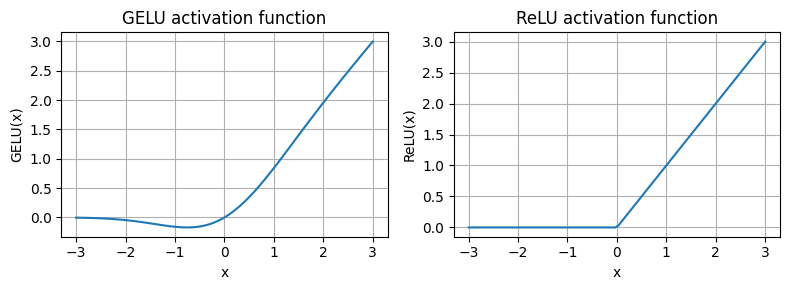

In [35]:
import matplotlib.pyplot as plt

gelu, relu = Gelu(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [37]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["embedding_dim"], cfg["embedding_dim"] * 4),
            Gelu(),
            nn.Linear(cfg["embedding_dim"] * 4, cfg["embedding_dim"]),
        )

    def forward(self, x):
        return self.layers(x)
    
    # embedding dimension multiplied by 4 during feed forward
    # for more complex representation of the input


In [39]:
# testing the feedforward layer
ff = FeedForward(GPT_CONFIG_124M)
batch_example = torch.randn(2,3,768) #2 training examples, 3 tokens, 768 features
ff_out = ff(batch_example)

print(ff_out.shape) #  output shape is same as input shape
print(ff_out)

torch.Size([2, 3, 768])
tensor([[[-0.2099,  0.0590, -0.0855,  ..., -0.0980,  0.5409, -0.1994],
         [-0.2449, -0.1778,  0.2034,  ...,  0.1459,  0.0173,  0.2123],
         [ 0.1266, -0.1725,  0.3145,  ...,  0.1970,  0.3086, -0.3508]],

        [[ 0.0276, -0.0985, -0.0204,  ..., -0.1164,  0.1293,  0.1607],
         [ 0.0415,  0.1997, -0.0266,  ...,  0.0007, -0.0506,  0.0007],
         [ 0.0086,  0.2381, -0.2547,  ..., -0.0476,  0.1593, -0.0455]]],
       grad_fn=<ViewBackward0>)


Adding Shortcut Connections

In [41]:
# shortcuts help reduce vanishing gradient problem
# by adding the input to the output of the layer

class Residual(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut

        # 5 layers
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), Gelu()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), Gelu()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), Gelu()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), Gelu()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), Gelu())

        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                # add the input to the output
                x = x + layer_output
            else:
                x = layer_output
        return x

In [42]:
# test the residual block

layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([1.0, 0.0, -1.0])
torch.manual_seed(123) #A 
model_without_shortcut = Residual(
    layer_sizes, use_shortcut=False
)